In [1]:
import pandas as pd
import glob
import yaml
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
filepaths = yaml.safe_load(open("../config/filepaths.yaml"))

# Manual 
https://buckeyecorpus.osu.edu/BuckeyeCorpusmanual.pdf

In [3]:
def get_sentences_df(file):
    try:
        s = open(file).read()
        lines = s.split('\n')
        df = pd.DataFrame(lines, columns=['original'])
        # df = pd.DataFrame(lines, columns=['sentence'])
        # df['tags'] = df.sentence.str.split(' ').apply(lambda x: [w for w in x if '<' in w or '>' in w])
        # df['original'] = df['sentence']
        # df.sentence = df.sentence.apply(lambda x: " ".join([w for w in x.split(' ') if '>' not in w and '<' not in w]))
        df['part'] = file.split('/')[-1].split('.')[0]
        return df
    except:
        print(file)

In [4]:
df = pd.DataFrame()
for folder in glob.glob(filepaths['buckeye_original_textfiles']+'*'):
    name = folder.split('/')[-1]
    tmp = pd.concat([get_sentences_df(d) for d in glob.glob(folder+'/*.txt')])
    tmp['interviewed'] = name
    df = df.append(tmp)
df = df.reset_index(drop=True)
df.head()

,original,part,interviewed
0,<VOCNOISE> <SIL> <VOCNOISE> <VOCNOISE=brrr> <S...,s3502a,s35
1,yeah <IVER>,s3502a,s35
2,yeah it did and then she <CUTOFF-tuh=?> <VOCNO...,s3502a,s35
3,they'd uh heard it all before and they <UNKNOW...,s3502a,s35
4,<VOCNOISE> well i wasn't i was in <CUTOFF-mana...,s3502a,s35


In [5]:
def process_tags(s,SIL=True):
    processed = []
    exclude = False
    for w in s.split(' '):
        if exclude and '{E_THIRD_SPKR}' in w:
            exclude = False
            continue

        if exclude:
            continue

        if '{B_THIRD_SPKR}' in w:
            exclude = True
            continue

        if '{B_TRANS}' in w or '{E_TRANS}' in w:
            continue

        if '<' not in w:
            processed.append(w)
            continue

        if 'EXCLUDE' in w or 'VOICE' in w or 'IVER' in w:
            continue
        
        if 'SIL' in w and SIL:
            processed.append(w)
            continue
        
        if '-' in w:
            if '=' not in w:            
                tag_w = w.replace('>','').split('-')[-1]
                tag_w = [i for i in tag_w.split('_')]
                for i in tag_w:
                    processed.append(i)
                continue
            else:
                tag_w = w.replace('>','').split('-')[-1].split('=')[-1]
                tag_w = [i for i in tag_w.split('_')]
                for i in tag_w:
                    processed.append(i)
                continue
        
    processed = ' '.join(processed)
    return processed

In [6]:
df['sentence'] = df.original.apply(lambda x: process_tags(x,SIL=False))
df.head()

,original,part,interviewed,sentence
0,<VOCNOISE> <SIL> <VOCNOISE> <VOCNOISE=brrr> <S...,s3502a,s35,she couldn't understand accept the fact that y...
1,yeah <IVER>,s3502a,s35,yeah
2,yeah it did and then she <CUTOFF-tuh=?> <VOCNO...,s3502a,s35,yeah it did and then she ? but she was kind of...
3,they'd uh heard it all before and they <UNKNOW...,s3502a,s35,they'd uh heard it all before and they some of...
4,<VOCNOISE> well i wasn't i was in <CUTOFF-mana...,s3502a,s35,well i wasn't i was in management for about th...


<AxesSubplot:>

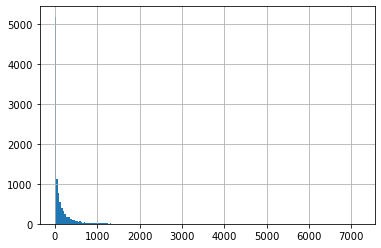

In [7]:
df.sentence.str.len().hist(bins=200)

In [9]:
# PERSPECTIVE_MAX_LEN = 2999
# df.loc[df.sentence.str.len()>PERSPECTIVE_MAX_LEN,'sentence'] = df.loc[df.sentence.str.len()>PERSPECTIVE_MAX_LEN,'original'].apply(lambda x: process_tags(x,SIL=True).split('<SIL>'))
# df = df.explode('sentence').reset_index(drop=True)
# print('len df:',len(df))
# print('max len sentence',df.sentence.str.len().max())
# df.sentence.str.len().hist(bins=200)
# plt.show()


In [10]:
def cut_on_n(s,n=2999):
    sentences = []
    last_space = 0
    last_cut = 0
    count = 0
    for i in range(len(s)):
        if s[i] == ' ':
            last_space = i
        if i > count+n:
            sentences.append(s[last_cut:last_space])
            count += last_space - last_cut
            last_cut = last_space+1 

    sentences.append(s[last_cut:])

    return sentences

df.sentence = df.sentence.apply(lambda x: cut_on_n(x))
df = df.explode('sentence').reset_index(drop=True)
df.sentence.str.len().max()

3000

<AxesSubplot:>

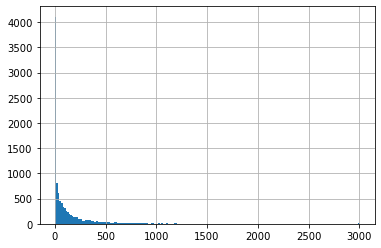

In [11]:
df.sentence.str.len().hist(bins=200)

In [12]:
df[df.sentence.str.len()==1].sentence.unique()

array(['i', '?', 'I'], dtype=object)

In [13]:
filtred = df[df.sentence.str.len()>1].reset_index(drop=True)
filtred

,original,part,interviewed,sentence
0,<VOCNOISE> <SIL> <VOCNOISE> <VOCNOISE=brrr> <S...,s3502a,s35,she couldn't understand accept the fact that y...
1,yeah <IVER>,s3502a,s35,yeah
2,yeah it did and then she <CUTOFF-tuh=?> <VOCNO...,s3502a,s35,yeah it did and then she ? but she was kind of...
3,they'd uh heard it all before and they <UNKNOW...,s3502a,s35,they'd uh heard it all before and they some of...
4,<VOCNOISE> well i wasn't i was in <CUTOFF-mana...,s3502a,s35,well i wasn't i was in management for about th...
...,...,...,...,...
9192,really <LAUGH> <IVER>,s3701a,s37,really
9193,are they friendlier other than than the koalas...,s3701a,s37,are they friendlier other than than the koalas
9194,yeah can you go up and like feed them and <IVER>,s3701a,s37,yeah can you go up and like feed them and
9195,um-hum <IVER>,s3701a,s37,um-hum


In [16]:
for i in filtred.interviewed.unique():
    filtred[filtred.interviewed==i][['sentence']].rename(columns={'sentence':'text'}).to_csv(filepaths['buckeye_senteces']+i+'.csv',index=False)